# PyTorch Siamese networks

We can use PyTorch to implement siamese networks to compare images on similarity.

In [29]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image, ImageFilter, ImageChops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_and_extract_archive

import requests
import copy
import os
import random
from io import BytesIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset
We use the AT&T Faces dataset here.  
https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/


This is a bit of a strange one as the images come in the '.pgm' Format and need to be converted.

In [5]:
url = 'https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/archive/refs/heads/master.zip'
target_path = './tmp/faces_repos/'
if not os.path.exists(target_path):
    os.makedirs(target_path)
    if len(os.listdir(target_path)) == 0:
        download_and_extract_archive(url=url, download_root=target_path)
    else:
        print("Dataset already exists, skipping download and extraction...")

4218688it [00:00, 10399867.85it/s]


Extracting ./tmp/faces_repos/master.zip to ./tmp/faces_repos/


In [20]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    

In [17]:
converted_path = './tmp/att_faces/'
for root, subdirs, files in os.walk(target_path):
    for filename in files:
        file_path = os.path.join(root, filename)
        filename, extension  = os.path.splitext(filename)

        if extension == ".pgm":
            path = os.path.normpath(file_path)
            splits = path.split(os.sep)
            new_file_path = os.path.join(converted_path, splits[-3], splits[-2], f'{filename}.png')
            with Image.open(file_path) as im:
                dir = os.path.dirname(new_file_path)
                if not os.path.exists(dir):
                    os.makedirs(dir)
                im.save(new_file_path)

In [42]:
train_folder_dataset = ImageFolder(root='./tmp/att_faces/training')
test_folder_dataset = ImageFolder(root='./tmp/att_faces/testing')

In [46]:
ds_transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=train_folder_dataset,
                                        transform=ds_transform,
                                        should_invert=False)

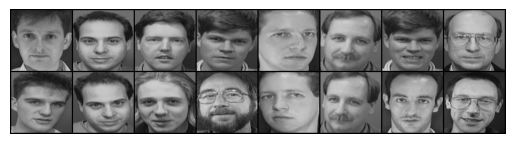

[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [31]:
dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=8)

dataiter = iter(dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)

img = make_grid(concatenated)
npimg = img.numpy()
plt.axis("off")
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()   

print(example_batch[2].numpy())

## Define Network

In [32]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),)

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive loss function

In [33]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Instantiate network and start training

In [37]:
net = SiameseNetwork().to(device)

criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0005 )

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

Total train progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0, Current loss: 0.018552584573626518


Epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1, Current loss: 0.012282023206353188


Epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2, Current loss: 0.026647185906767845


Epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3, Current loss: 0.020212754607200623


Epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faa4386e8b0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faa4386e8b0>Traceback (most recent call last):

  File "/home/user/mambaforge/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/home/user/mambaforge/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()
Exception ignored in:       File "/home/user/mambaforge/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7faa4386e8b0>    

if w.is_alive():Traceback (most recent call last):
  File "/home/user/mambaforge/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/home/user/mambaforge/lib/python3.9/site-packages/torch/utils/

Epoch: 4, Current loss: 0.010439170524477959


Epoch 6:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5, Current loss: 0.03570746257901192


Epoch 7:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 6, Current loss: 0.00771446293219924


Epoch 8:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7, Current loss: 0.0371655635535717


Epoch 9:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 8, Current loss: 0.018859989941120148


Epoch 10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 9, Current loss: 0.024345960468053818


Epoch 11:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 10, Current loss: 0.029392238706350327


Epoch 12:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 11, Current loss: 0.022627821192145348


Epoch 13:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 12, Current loss: 0.03186532109975815


Epoch 14:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 13, Current loss: 0.010664867237210274


Epoch 15:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 14, Current loss: 0.01329056452959776


Epoch 16:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 15, Current loss: 0.06234617903828621


Epoch 17:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 16, Current loss: 0.028619596734642982


Epoch 18:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 17, Current loss: 0.04067691043019295


Epoch 19:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 18, Current loss: 0.022130105644464493


Epoch 20:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 19, Current loss: 0.03729908913373947


Epoch 21:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 20, Current loss: 0.008355937898159027


Epoch 22:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 21, Current loss: 0.015918489545583725


Epoch 23:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 22, Current loss: 0.02160145714879036


Epoch 24:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 23, Current loss: 0.02407214231789112


Epoch 25:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 24, Current loss: 0.014073781669139862


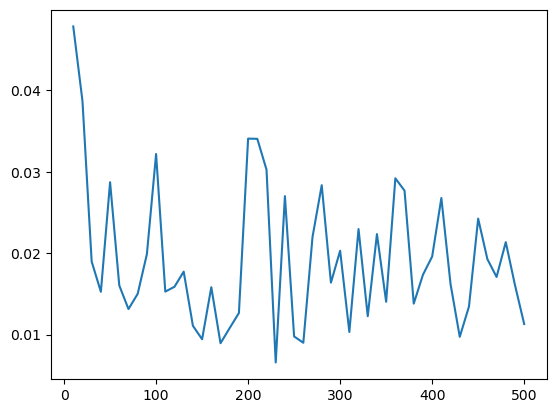

In [40]:
counter = []
loss_history = [] 
iteration_number= 0
epochs = 25

for epoch in tqdm(range(epochs), desc="Total train progress", position=0):
    for i, data in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch + 1}', position=1, leave=False), 0):
        img_0, img_1 , label = data
        img_0, img_1 , label = img_0.to(device), img_1.to(device) , label.to(device)
        optimizer.zero_grad()
        output_1, output_2 = net(img_0, img_1)
        loss_contrastive = criterion(output_1, output_2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    print(f"Epoch: {epoch}, Current loss: {loss_contrastive.item()}")    

plt.plot(counter,loss_history)
plt.show()

## Show results

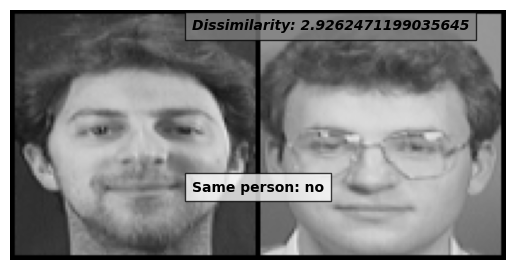

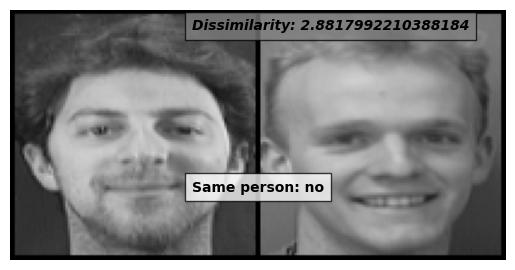

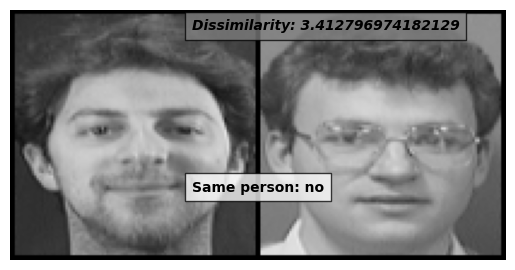

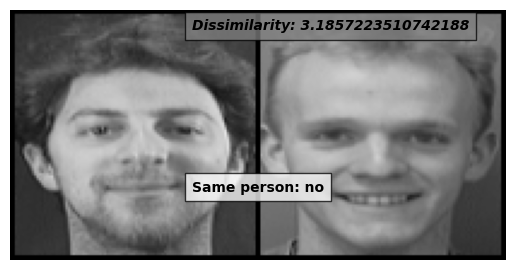

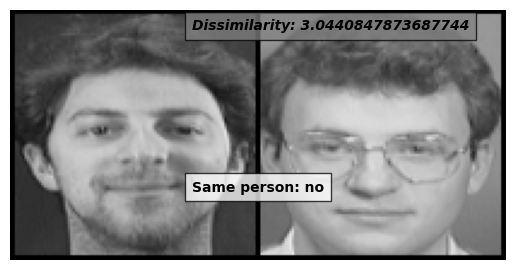

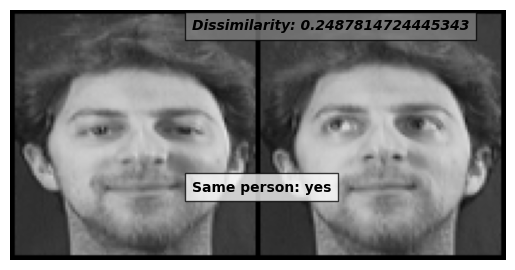

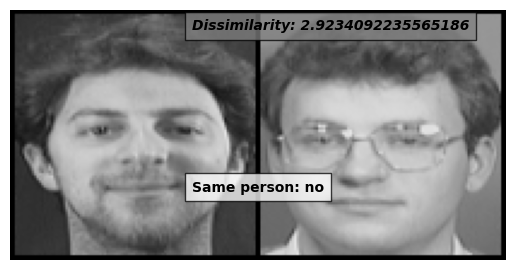

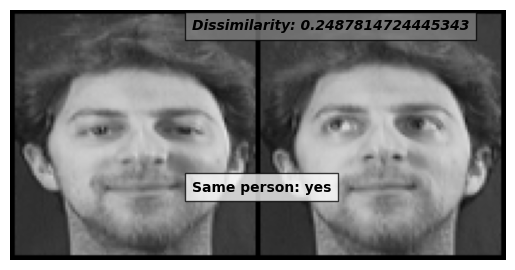

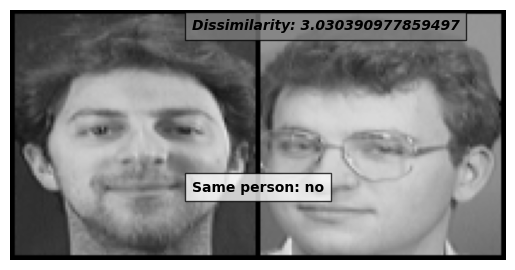

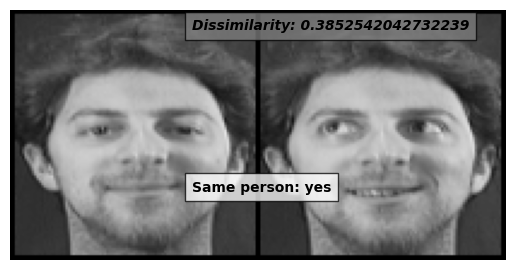

In [53]:
from torch.autograd import Variable

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=test_folder_dataset,
                                        transform=ds_transform,
                                        should_invert=False)

test_dataloader = DataLoader(siamese_dataset, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
img_0, _, _ = next(dataiter)

for i in range(10):
    _, img_1, _ = next(dataiter)
    concatenated = torch.cat((img_0, img_1), 0)
    
    output_1, output_2 = net(Variable(img_0).to(device), Variable(img_1).to(device))
    euclidean_distance = F.pairwise_distance(output_1, output_2)

    # show image
    img = make_grid(concatenated)
    dissimilarity = euclidean_distance.item()
    text = f'Dissimilarity: {dissimilarity}'
    verdict = 'yes' if dissimilarity < 1.0 else 'no'
    npimg = img.numpy()
    plt.axis("off")
    plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'gray', 'alpha':0.75, 'pad':5})
    plt.text(75, 75, f'Same person: {verdict}', fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.75, 'pad':5})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()   